<a href="https://colab.research.google.com/github/Tim-Li/X-ray_summer_school_2022/blob/main/Python%E5%AF%A6%E4%BD%9C_Day2%EF%BC%9A%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%9C%A8%E4%B8%89%E7%B6%ADX%E5%85%89%E5%BD%B1%E5%83%8F%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python實作 Day2：深度學習在三維X光影像應用

# 操作說明

## X光影像分割流程

### 1️⃣模型訓練

### 2️⃣模型預測

## 實作流程

# python實作：

## 環境建置

### 1.開啟GPU的操作


### 2.安裝python函式庫

### 3.載入python函式庫

In [ ]:
import numpy as np
from pathlib import Path
import gdown
import glob
import time
from matplotlib import pyplot as plt
from PIL import Image
import tifffile

In [ ]:
%matplotlib inline
from ipywidgets import interact

In [ ]:
from tqdm import tqdm
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Nadam
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

### 4.建立運作資料夾(暫存區）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = Path("day_2:segmentation")
project_dir.mkdir(exist_ok=True)

## 影像分割模型訓練（unet）

### 1.下載資料集(spleen)

In [ ]:
%cd $project_dir
url = "https://drive.google.com/uc?id=1AaULrJUGfNshC_Q_X3EWz50KYpRyFTrT&export=download"
output = "temp.zip"
gdown.download(url, output)
!unzip temp.zip
!rm temp.zip
url = "https://drive.google.com/uc?id=1mRX3m2MH2TSJ8FxUyWjaXRqQV5n4omM5&export=download"
gdown.download(url)
!mv model_unet.py '/usr/local/lib/python3.7/dist-packages'
%cd ..

/content/day_2:segmentation


Downloading...
From: https://drive.google.com/uc?id=1AaULrJUGfNshC_Q_X3EWz50KYpRyFTrT&export=download
To: /content/day_2:segmentation/temp.zip
100%|██████████| 6.06M/6.06M [00:00<00:00, 102MB/s]


Archive:  temp.zip
   creating: raw_uint8/
   creating: raw_uint8/train_images/
  inflating: raw_uint8/train_images/image_00000.tif  
  inflating: raw_uint8/train_images/image_00001.tif  
  inflating: raw_uint8/train_images/image_00002.tif  
  inflating: raw_uint8/train_images/image_00003.tif  
  inflating: raw_uint8/train_images/image_00004.tif  
  inflating: raw_uint8/train_images/image_00005.tif  
  inflating: raw_uint8/train_images/image_00006.tif  
  inflating: raw_uint8/train_images/image_00007.tif  
  inflating: raw_uint8/train_images/image_00008.tif  
  inflating: raw_uint8/train_images/image_00009.tif  
  inflating: raw_uint8/train_images/image_00010.tif  
  inflating: raw_uint8/train_images/image_00011.tif  
  inflating: raw_uint8/train_images/image_00012.tif  
  inflating: raw_uint8/train_images/image_00013.tif  
  inflating: raw_uint8/train_images/image_00014.tif  
  inflating: raw_uint8/train_images/image_00015.tif  
  inflating: raw_uint8/train_images/image_00016.tif  
  

Downloading...
From: https://drive.google.com/uc?id=1mRX3m2MH2TSJ8FxUyWjaXRqQV5n4omM5&export=download
To: /content/day_2:segmentation/model_unet.py
100%|██████████| 1.76k/1.76k [00:00<00:00, 505kB/s]

/content


### 2.載入數據集(訓練、驗證)

訓練數據(images、label)

In [ ]:
SIZE=512
img_data1=[]
path1 = '/content/day_2:segmentation/raw_uint8/train_images'
files1=sorted(os.listdir(path1))
for i in tqdm(files1):
    img1 = tifffile.imread(path1+'/'+i)
    img1=cv2.resize(img1,(SIZE, SIZE))
    img_data1.append(img_to_array(img1))

img_array1 = np.reshape(img_data1, (len(img_data1), SIZE, SIZE, 1))
img_array1 = img_array1.astype('float32')/255

100%|██████████| 55/55 [00:00<00:00, 470.02it/s]


In [ ]:
img_data2=[]
path2 = '/content/day_2:segmentation/raw/train_label_raw'
files2=sorted(os.listdir(path2))
for i in tqdm(files2):
    img2 = tifffile.imread(path2+'/'+i)
    img2=cv2.resize(img2,(SIZE, SIZE))
    img_data2.append(img_to_array(img2))

img_array2 = np.reshape(img_data2, (len(img_data2), SIZE, SIZE, 1))
img_array2 = img_array2.astype('float32')/255

100%|██████████| 55/55 [00:00<00:00, 191.49it/s]


In [ ]:
nf,_,_,_ = img_array1.shape
def browse_images(x_train,y_train):
    n = nf
    def view_image(layer):
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(np.reshape(img_array1[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.subplot(122)
        plt.imshow(np.reshape(img_array2[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(img_array1,img_array2)

interactive(children=(IntSlider(value=27, description='layer', max=54), Output()), _dom_classes=('widget-inter…

validation data

In [ ]:
img_data3=[]
path1 = '/content/day_2:segmentation/raw/train_image_raw'
files=sorted(os.listdir(path1))
for i in tqdm(files):
    img = tifffile.imread(path1+'/'+i)
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 1))
img_array = img_array.astype('float32')/255

In [ ]:
img_data1=[]
path2 = '/content/day_2:segmentation/raw/train_label_raw'
files1=sorted(os.listdir(path2))
for i in tqdm(files1):
    img1 = tifffile.imread(path2+'/'+i)
    img1=cv2.resize(img1,(SIZE, SIZE))
    img_data1.append(img_to_array(img1))

img_array1 = np.reshape(img_data1, (len(img_data1), SIZE, SIZE, 1))
img_array1 = img_array1.astype('float32')/255

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_array, img_array1, test_size = 0, random_state = 0)
print(x_train.shape, x_test.shape)

In [ ]:
nf,_,_,_ = x_train.shape
def browse_images(x_train,y_train):
    n = nf
    def view_image(layer):
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(np.reshape(x_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.subplot(122)
        plt.imshow(np.reshape(y_train[layer], (SIZE, SIZE)), cmap='gray', interpolation='nearest')
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(x_train,y_train)

interactive(children=(IntSlider(value=24, description='layer', max=48), Output()), _dom_classes=('widget-inter…

In [ ]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
from model_unet import build_unet
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
img_shape=(SIZE, SIZE,1)
unet_model=build_unet(img_shape)
unet_model.compile(optimizer=Nadam, loss='mean_squared_error', metrics=['acc'])

(None, 32, 32, 1024)
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                        

In [ ]:
save_model_dir = Path(project_dir/"trained_model")
save_model_dir.mkdir(exist_ok=True)

In [ ]:
bs=4
ep=20
path= str(save_model_dir)+f'/_b{int(bs)}_epochs{int(ep)}.h5'
model_checkpoint = ModelCheckpoint(path,monitor='loss', verbose=1, save_best_only=True)
history = unet_model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = bs,
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_checkpoint],
                    epochs=ep)

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 0.1265 - acc: 0.8790
Epoch 1: loss improved from inf to 0.12648, saving model to day_2:segmentation/trained_model/_b4_epochs20.h5
13/13 [==============================] - 59s 2s/step - loss: 0.1265 - acc: 0.8790 - val_loss: 0.7856 - val_acc: 0.0738
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.0650 - acc: 0.9477
Epoch 2: loss improved from 0.12648 to 0.06502, saving model to day_2:segmentation/trained_model/_b4_epochs20.h5
13/13 [==============================] - 14s 1s/step - loss: 0.0650 - acc: 0.9477 - val_loss: 0.5024 - val_acc: 0.4949
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.0403 - acc: 0.9675
Epoch 3: loss improved from 0.06502 to 0.04035, saving model to day_2:segmentation/trained_model/_b4_epochs20.h5
13/13 [==============================] - 14s 1s/step - loss: 0.0403 - acc: 0.9675 - val_loss: 0.4914 - val_acc: 0.4994
Epoch 4/20
13/13 [=======================

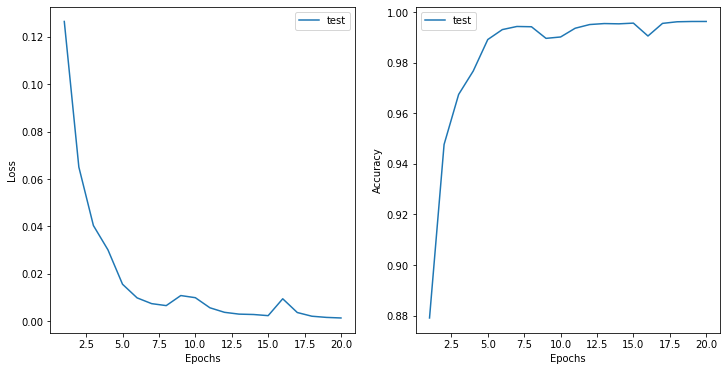

In [ ]:
loss = history.history['loss']
acc = history.history['acc']
epoch = range(1, ep+1)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(epoch,loss, label='test')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(epoch,acc, label='test')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load the model 
from keras.models import load_model
unet_model = load_model("/home/txm/work_code/TXM_AI_project/DLFBP-TXM/model/sy_b1_epochs10_feature64.h5", compile=False)

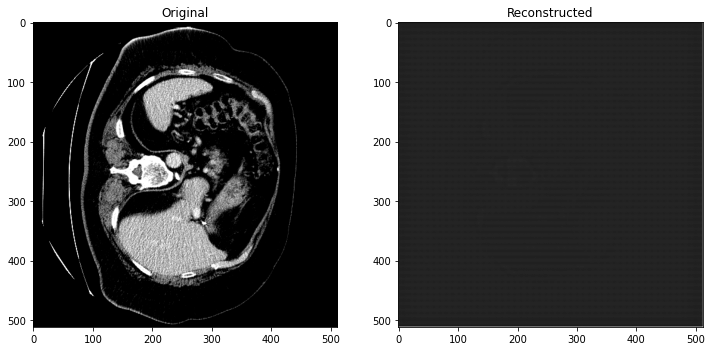

In [ ]:
img1 = tifffile.imread('/content/day_2:segmentation/raw/train_image_raw/input_00030.tif')
img1=cv2.resize(img1,(SIZE, SIZE))
img_array1 = img1.astype('float32') / 255.

test_img = np.expand_dims(img_array1, axis=0)
pred = unet_model.predict(test_img)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(test_img[0],cmap='gray')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE),cmap='gray')
plt.title('Reconstructed')
plt.show()

In [ ]:
import glob
from PIL import Image

index = 0
msg = '/home/txm/work_code/TXM_AI_project/1.Incomplete_CT_data/DLFBP-TXM/Data/real_data/tomo-zinc/corr_sion/'
imfile = sorted(glob.glob(msg+"*"+".tif"))
path='/home/txm/work_code/TXM_AI_project/1.Incomplete_CT_data/DLFBP-TXM/Data/real_data/tomo-zinc/Ai_z2/'
print("Start Predict !!")
for i in imfile:
    print(i,index)
    img1=cv2.imread(i, 0)
    img1=cv2.resize(img1,(SIZE, SIZE))
    img_array1 = img1.astype('float32') / 255.
    test_img = np.expand_dims(img_array1, axis=0)
    pred = DLFBP_model.predict(test_img)
    a=pred[0].reshape(SIZE,SIZE)*255  
    sinogram = Image.fromarray(a)
    if sinogram.mode == "F":
        sinogram = sinogram.convert('L') 
    sinogram.save(path+f'P_{str(index).zfill(3)}.tif')
    index += 1
print("Predict Done !!",len(imfile),"images")

In [ ]:
test_img[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
pred[0]

array([[[0.05685843],
        [0.06101801],
        [0.04777256],
        ...,
        [0.05387868],
        [0.05153383],
        [0.06101648]],

       [[0.05470292],
        [0.0314451 ],
        [0.0361602 ],
        ...,
        [0.03032171],
        [0.04122969],
        [0.04482414]],

       [[0.05014497],
        [0.04631443],
        [0.0330064 ],
        ...,
        [0.03927964],
        [0.03736656],
        [0.04737534]],

       ...,

       [[0.05642255],
        [0.03006471],
        [0.03330892],
        ...,
        [0.02971134],
        [0.03780198],
        [0.04577243]],

       [[0.05679599],
        [0.04701721],
        [0.03821166],
        ...,
        [0.03948814],
        [0.04022748],
        [0.04425057]],

       [[0.06828376],
        [0.05748457],
        [0.05828008],
        ...,
        [0.0605074 ],
        [0.05945672],
        [0.08071201]]], dtype=float32)

In [ ]:
pred[0].shape

(512, 512, 1)